In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

In [1]:
prom_file_path = "prom_pure_label.parquet"

In [4]:
prom_df = pd.read_parquet(prom_file_path)

In [13]:
prom_df

,timestamp,node,node_load15,node_load5,node_load1,node_memory_Active_bytes,node_filesystem_device_error-sum,node_netstat_Icmp_InErrors,node_netstat_Tcp_InErrs,node_netstat_Udp_InErrors,nvidia_gpu_power_usage_milliwatts-max,nvidia_gpu_temperature_celsius-max,isAnomaly
0,2022-08-01 23:00:30,r12n20,3.25,2.43,4.40,4.585050e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
1,2022-08-01 23:01:00,r12n20,3.21,2.41,3.49,4.195340e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
2,2022-08-01 23:01:30,r12n20,3.14,2.27,2.51,4.248640e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
3,2022-08-01 23:02:00,r12n20,3.07,2.15,1.91,4.248610e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
4,2022-08-01 23:02:30,r12n20,3.01,2.05,1.63,4.266120e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123565292,2022-09-30 11:20:00,r35n5,6.33,2.92,1.16,1.612260e+10,0.0,97.0,0.0,0.0,156186.0,57.0,0
123565293,2022-09-30 11:20:30,r35n5,6.16,2.73,1.10,1.610200e+10,0.0,97.0,0.0,0.0,160405.0,55.0,0
123565294,2022-09-30 11:21:00,r35n5,5.99,2.55,0.99,1.612250e+10,0.0,97.0,0.0,0.0,165284.0,58.0,0
123565295,2022-09-30 11:21:30,r35n5,5.83,2.40,1.00,1.612330e+10,0.0,97.0,0.0,0.0,164491.0,60.0,0


In [6]:
prom_df = prom_df.drop('NodeName', axis=1)

prom_df = prom_df.drop('CPUTot', axis=1)
prom_df = prom_df.drop('RealMemory', axis=1)
prom_df = prom_df.drop('GPU Model', axis=1)
prom_df = prom_df.drop('GPU Count', axis=1)

In [8]:
def is_anomaly(total_anomaly):
    if total_anomaly == 0:
        return 0
    else:
        return 1
prom_df['isAnomaly'] = prom_df['total_anomaly'].apply(is_anomaly)

In [10]:
prom_df = prom_df.drop('total_anomaly', axis=1)

In [12]:
prom_df.to_parquet('prom_pure_label.parquet')

In [14]:

prom_df = prom_df.drop('node', axis=1)

prom_df = prom_df.drop('timestamp', axis=1)

feature_cols = [col for col in prom_df.columns if col != 'isAnomaly']

iforest = IsolationForest(contamination=0.028)

iforest.fit(prom_df[feature_cols])

pred = iforest.predict(prom_df[feature_cols])

pred_labels = [1 if i == -1 else 0 for i in pred]

print(classification_report(prom_df['isAnomaly'], pred_labels))
print(confusion_matrix(prom_df['isAnomaly'], pred_labels))


/home/wenjun/miniconda3/envs/python_env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.99      0.99 120006718
           1       0.54      0.53      0.53   3558579

    accuracy                           0.97 123565297
   macro avg       0.76      0.76      0.76 123565297
weighted avg       0.97      0.97      0.97 123565297

[[118424061   1582657]
 [  1681659   1876920]]


In [15]:
import joblib
model_filename = 'iforest_model.joblib'
joblib.dump(iforest, model_filename)

['iforest_model.joblib']

              precision    recall  f1-score   support

           0       0.99      0.99      0.99 120006718
           1       0.54      0.53      0.53   3558579

    accuracy                           0.97 123565297
   macro avg       0.76      0.76      0.76 123565297
weighted avg       0.97      0.97      0.97 123565297

Confusion matrix:
 [[118424061   1582657]
 [  1681659   1876920]]
ROC AUC Score: 0.7571235893557486


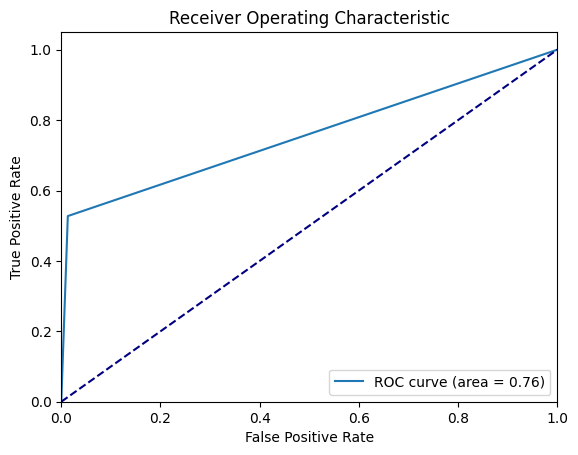

In [5]:
import joblib
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

iforest = joblib.load('iforest_model.joblib')

prom_df = prom_df.drop('node', axis=1)
prom_df = prom_df.drop('timestamp', axis=1)

feature_cols = [col for col in prom_df.columns if col != 'isAnomaly']

pred = iforest.predict(prom_df[feature_cols])

pred_labels = [1 if i == -1 else 0 for i in pred]

print(classification_report(prom_df['isAnomaly'], pred_labels))

conf_mat = confusion_matrix(prom_df['isAnomaly'], pred_labels)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(prom_df['isAnomaly'], pred_labels)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(prom_df['isAnomaly'], pred_labels)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.savefig('roc_curve.pdf', format='pdf')

plt.show()
